<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/sub-studies/backbones/resnet/notebooks/Set_1_7_Model_G_b_ret_res101_epoch100_oct20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Set_1_7 merged dataset, annotated, split in train/valid/test.

Train COCO-pretrained RetinaNet using Set_1_7 to generate Model_G_a.

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [2]:
exit()

In [ ]:
import icevision

In [2]:
from icevision.all import *
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.10.0a1
torch v 1.9.0+cu111
torchvision v 0.10.0+cu111


Use annotated Set_1_7

In [3]:
! git clone https://github.com/yrodriguezmd/Surgical_instruments.git

Cloning into 'Surgical_instruments'...
remote: Enumerating objects: 3447, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 3447 (delta 22), reused 9 (delta 9), pack-reused 3393
Receiving objects: 100% (3447/3447), 108.87 MiB | 32.50 MiB/s, done.
Resolving deltas: 100% (885/885), done.
Checking out files: 100% (4145/4145), done.


In [4]:
!ls Surgical_instruments/Sets/Set_S/subsets/Set_1_7
# merged dataset in Set_S subset

notebooks  README.md  test  train  valid  whole_set


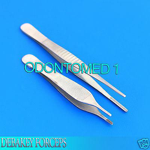

In [5]:
image_path = Path('Surgical_instruments/Sets/Set_S/subsets/Set_1_7/train')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[601]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [6]:
classes = ['Towel_clip', 'Castroviejo', 'Yankauer', 'Hemostat', 'Army_navy', 'Richardson', 'Potts', 'Iris', 'Bulldog', 'Forceps', 'Scalpel', 'Frazier', 'Needle', 'Weitlaner', 'Mayo_metz']
class_map = ClassMap(classes)
len(class_map)

16

Parse data

In [7]:
# temporary
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount = True)

In [8]:
!ls Surgical_instruments/Sets/Set_S/subsets/Set_1_7
#!ls gdrive/MyDrive/Surgical_instruments/Set_1_5.v1i.coco

notebooks  README.md  test  train  valid  whole_set


In [9]:
path = Path('Surgical_instruments/Sets/Set_S/subsets/Set_1_7') # adjust if use git clone vs gdrive
#path = Path('gdrive/MyDrive/Surgical_instruments/Set_1_5.v1i.coco')

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/Set_1_7_annotations.coco.json',
    #annotations_filepath = path/'train/Set_1_5_annotations.coco.json',
    #img_dir = path/'train'
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/Set_1_7_annotations.coco.json',
    #annotations_filepath = path/'valid/Set_1_5_annotations.coco.json',
    #img_dir = path/'valid'
    img_dir = path/'valid'
)

In [10]:
# dataset already split in annotation tool, maintain grouping

whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

  0%|          | 0/1323 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/677 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/186 [00:00<?, ?it/s]

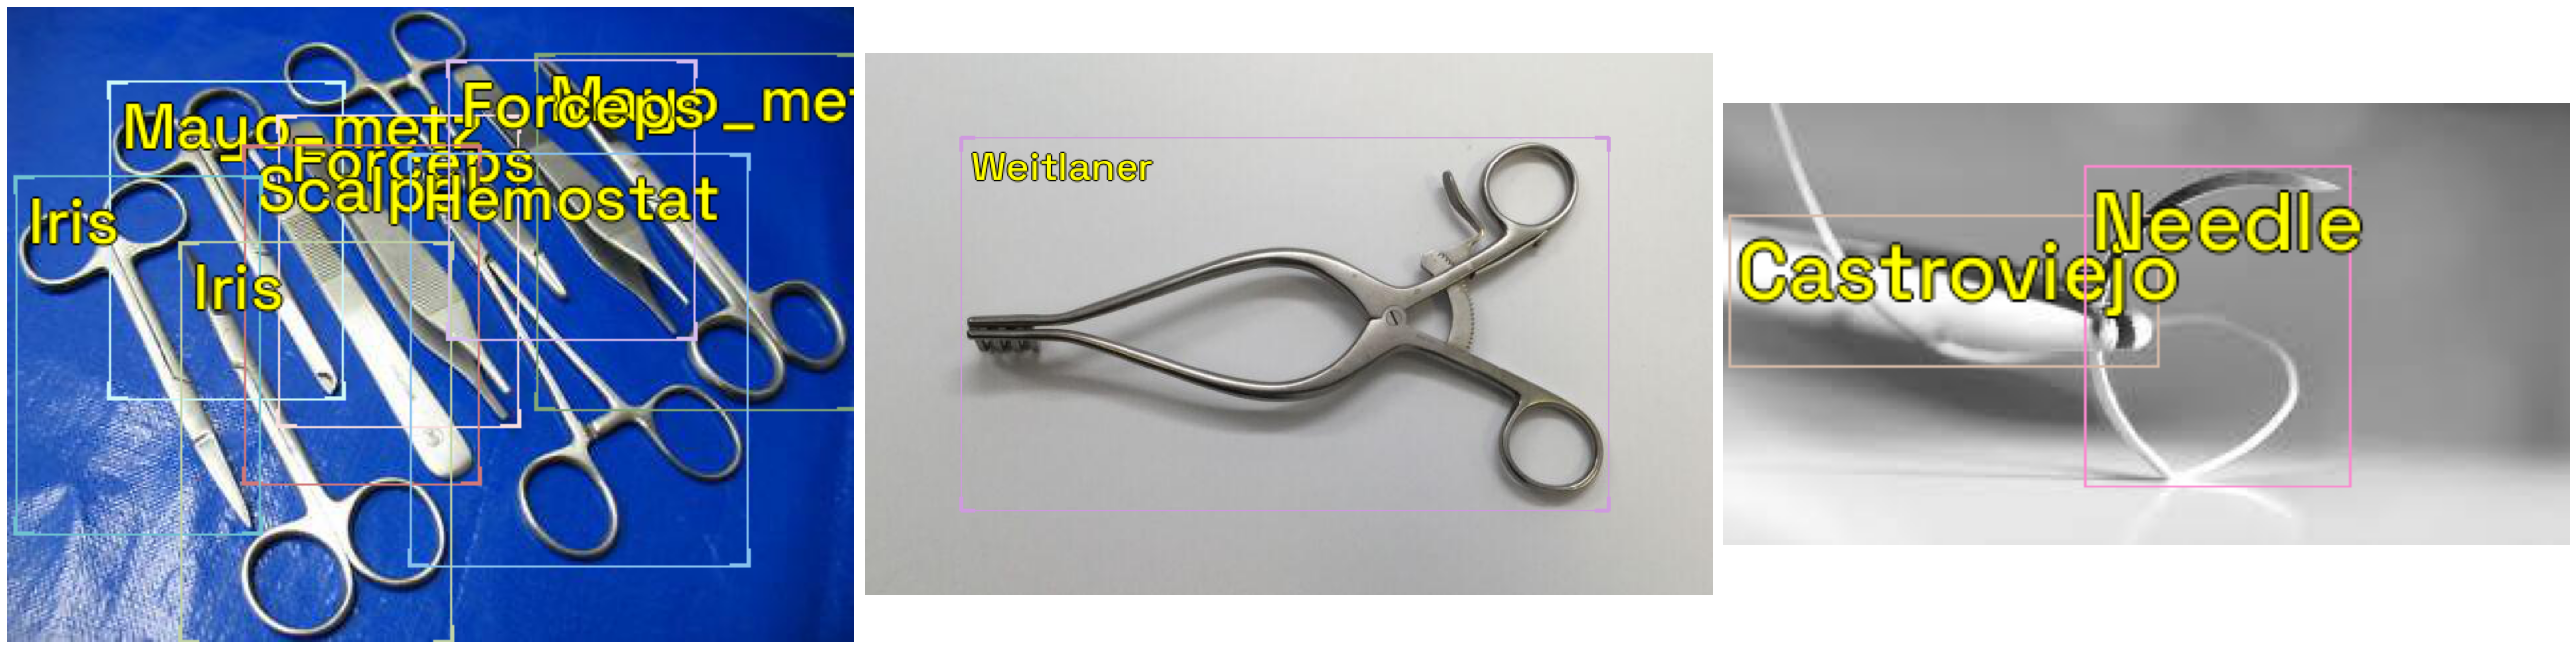

In [11]:
show_records(train_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

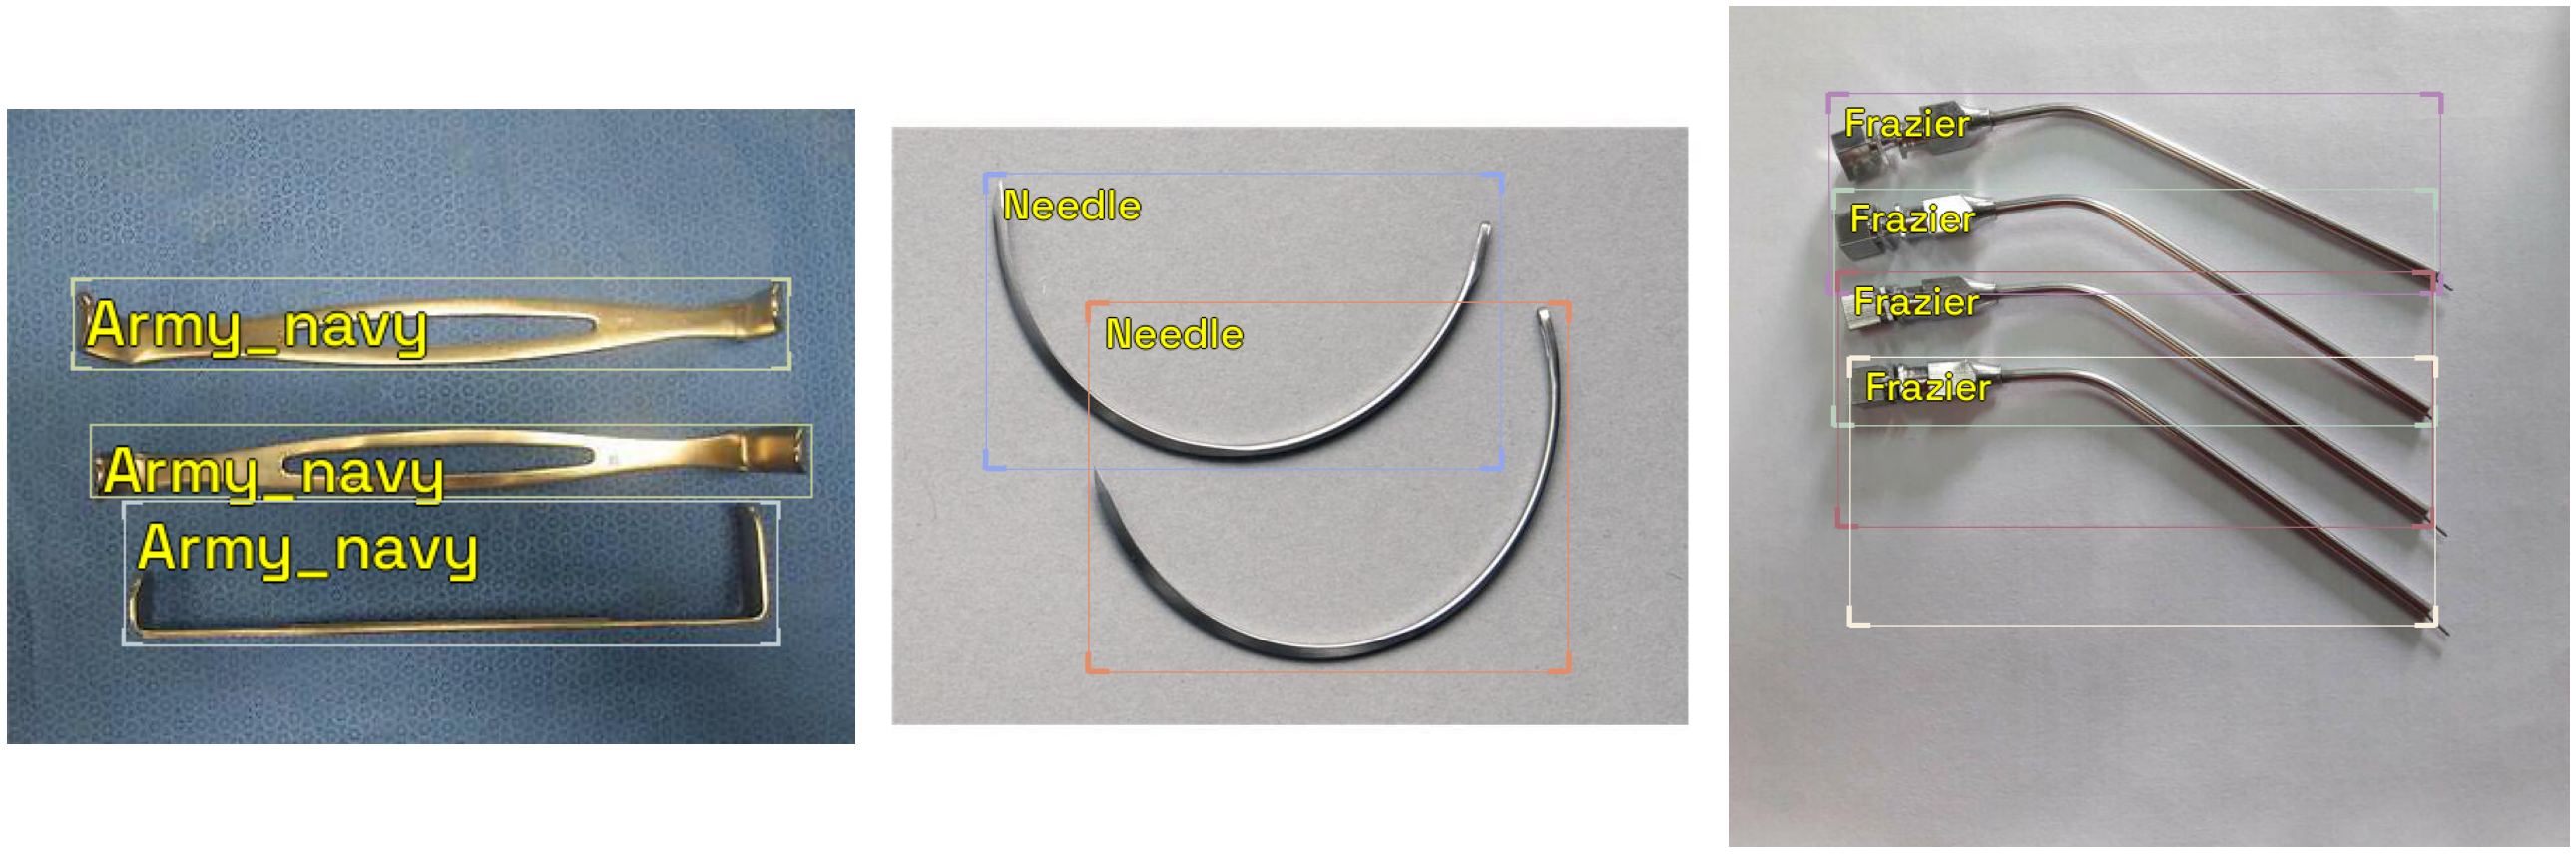

In [12]:
show_records(valid_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

In [46]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [47]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Fine-tune pretrained RetinaNet/resnet101 to generate teacher Model_G_b using Set_1_7 merged.  

In [48]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

from icevision.models.checkpoint import *

model_type = models.mmdet.retinanet ##
backbone = model_type.backbones.resnet101_fpn_1x##

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(class_map),)# **extra_args)

  0%|          | 0/228377232 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2021-10-20 20:42:52,999 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet101'}
2021-10-20 20:42:53,001 - mmcv - INFO - load model from: torchvision://resnet101
2021-10-20 20:42:53,002 - mmcv - INFO - Use load_from_torchvision loader
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

2021-10-20 20:42:56,529 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-10-20 20:42:56,590 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2021-10-20 20:42:56,645 - mmcv - INFO - initialize RetinaHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'retina_cls', 'std': 0.01, 'bias_prob': 0.01}}
2021-10-20 20:42:56,687 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet101 
 
2021-10-20 20:42:56,689 - mmcv - INFO - 
backbone.bn1.weight - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet101 
 
2021-10-20 20:42:56,690 - mmcv - INFO - 
backbone.bn1.bias - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet101 
 
2021-10-20 20:42:56,691 - mmcv - INFO - 
backbone.layer1.0.conv1.weight - torch.Size(

Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([135, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([135]).


In [ ]:
#checkpoint_path = 'Model_F_ret_mAP46.5.pth'

#checkpoint_and_model = model_from_checkpoint(checkpoint_path)

#model = checkpoint_and_model['model']
#model.train()

In [49]:
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

In [22]:
##
from fastai.callback.wandb import *

wandb.init(project = 'Surgical_instruments', name = 'Model_G_b_Set_1_7', ##
           reinit = True)

In [50]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,#)
                                  cbs = WandbCallback()) ##

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.00015848931798245758)

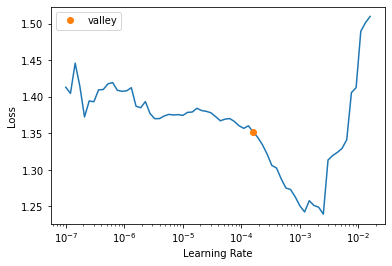

In [51]:
learn.lr_find()

In [52]:
# Set 1_7, retinanet resnet101, 
learn.fine_tune(100, 2e-04)

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


In [26]:
import matplotlib.pyplot as plt
def plot_metrics(learn, title):
  plt.plot(L(learn.recorder.values).itemgot())
  plt.xlabel('epoch')
  plt.ylabel('mAP (green), Loss (blue, orange)')
  plt.title(title)
  plt.text(0,-0.2, 
       'Legend: mAP(green), train_loss(blue), valid_loss(orange')
  plt.ylim(0,1);

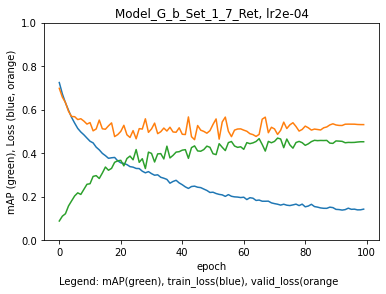

In [67]:
plot_metrics(learn, 'Model_G_b_Set_1_7_Ret, lr2e-04')

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


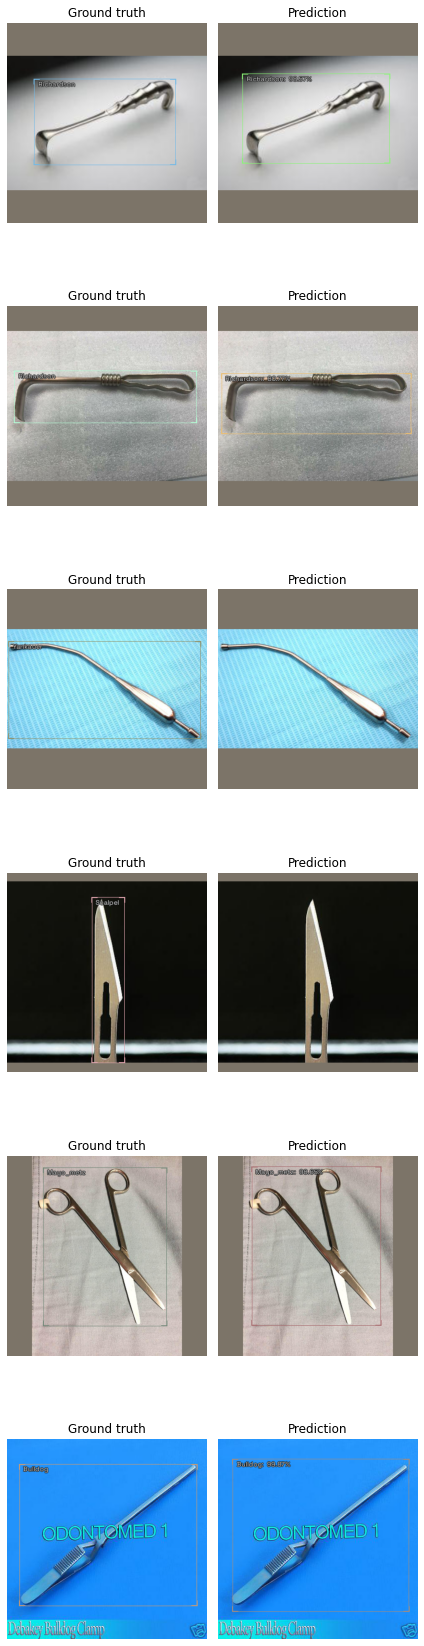

In [56]:
model_type.show_results(model, valid_ds)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


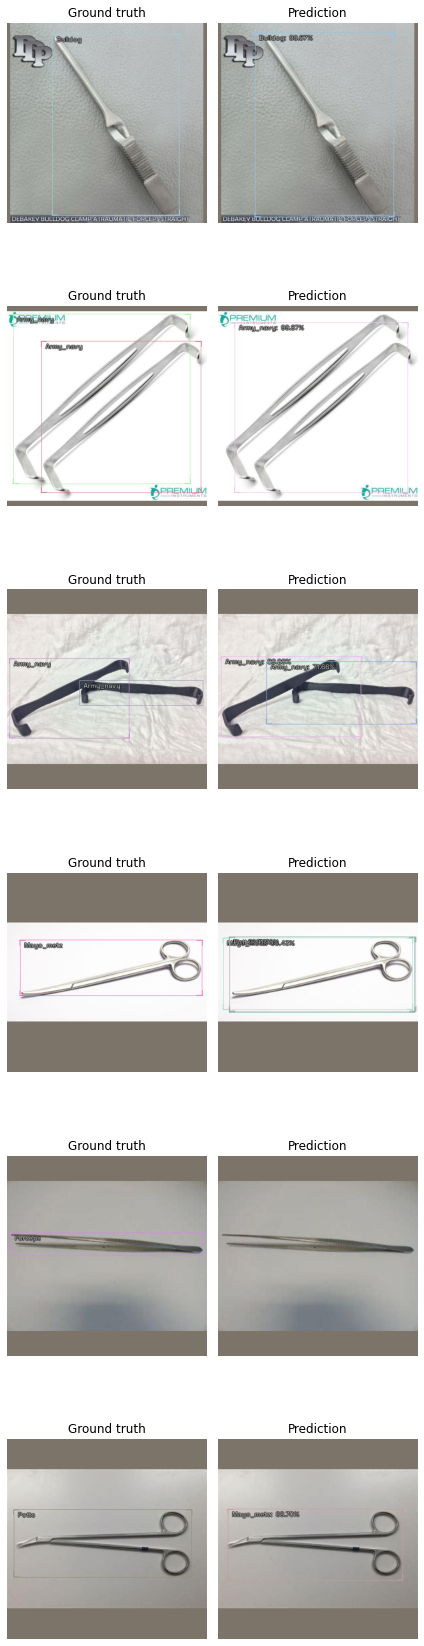

In [57]:
model_type.show_results(model, valid_ds)


In [58]:
from icevision.models import *

checkpoint_path = 'Model_G_b_ret_mAP45.4.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet101_fpn_1x', ##
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

# download model

In [59]:
# temporary
from google.colab import files
files.download('Model_G_b_ret_mAP45.4.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Inference 

In [60]:
path = Path('Surgical_instruments/Sets/Set_S/subsets/Set_1_7') # adjust if use git clone vs gdrive

test_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'test/Set_1_7_annotations.coco.json',
    #annotations_filepath = path/'train/Set_1_5_annotations.coco.json',
    #img_dir = path/'train'
    img_dir = path/'test')

In [61]:
whole = SingleSplitSplitter()

test_records, *_ = test_parser.parse(data_splitter = whole)

  0%|          | 0/185 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/93 [00:00<?, ?it/s]

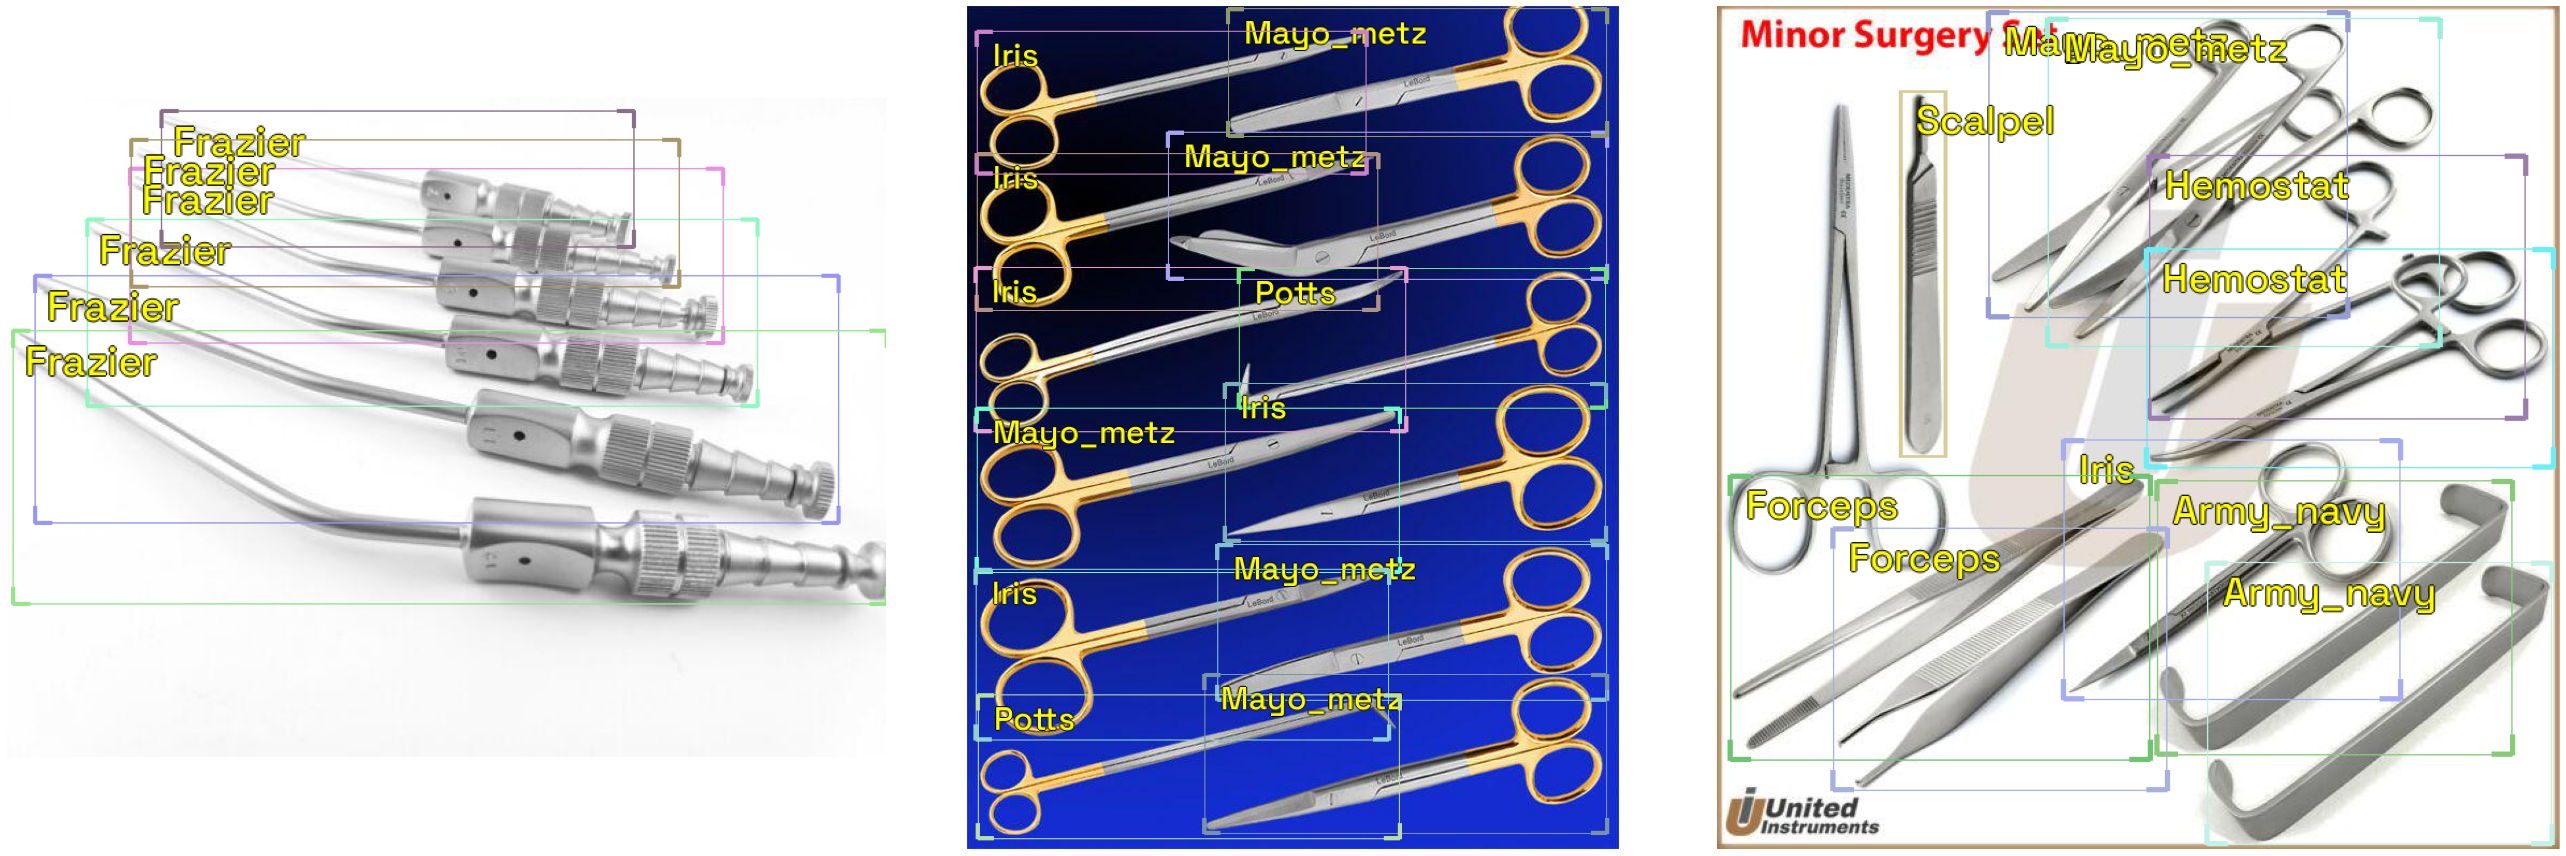

In [34]:
show_records(test_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

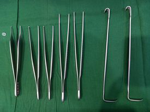

In [ ]:
#image_path = Path('Surgical_instruments/Sets/Set_7/raw_images')

#img_files = get_image_files(image_path)

#img = PIL.Image.open(img_files[0]) ##
#img = img.convert('RGB')

#img.to_thumb(150,150)

In [62]:
classes = ['Towel_clip', 'Castroviejo', 'Yankauer', 'Hemostat', 'Army_navy', 'Richardson', 'Potts', 'Iris', 'Bulldog', 'Forceps', 'Scalpel', 'Frazier', 'Needle', 'Weitlaner', 'Mayo_metz']
class_map = ClassMap(classes)

In [63]:
#imgs_array = [PIL.Image.open(file) for file in img_files]
#imgs_array = [PIL.Image.open(file) for file in test_records]

#imgs_array = [image.convert('RGB') for image in imgs_array]

img_size = 384 

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

#infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)
infer_ds = Dataset(test_records, valid_tfms)#, class_map = class_map)

Use Model G_b (trained on Set_1_7 from COCO-pretrained RetinaNet/ Resnet101)

In [ ]:
#from icevision.models import *

#checkpoint_path = 'Model_F_ret_mAP46.5.pth'

#checkpoint_and_model = model_from_checkpoint(checkpoint_path)
#model = checkpoint_and_model['model'] # Model F
model.eval()

Inference using Model G_b for Set_1_7 test_set.

In [65]:
infer_dl = model_type.infer_dl(infer_ds, 
                               batch_size=4, shuffle=False)

preds_saved = model_type.predict_from_dl(model, infer_dl,
                                          keep_images=True, 
                                         detection_threshold = 0.5) ##

  0%|          | 0/24 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


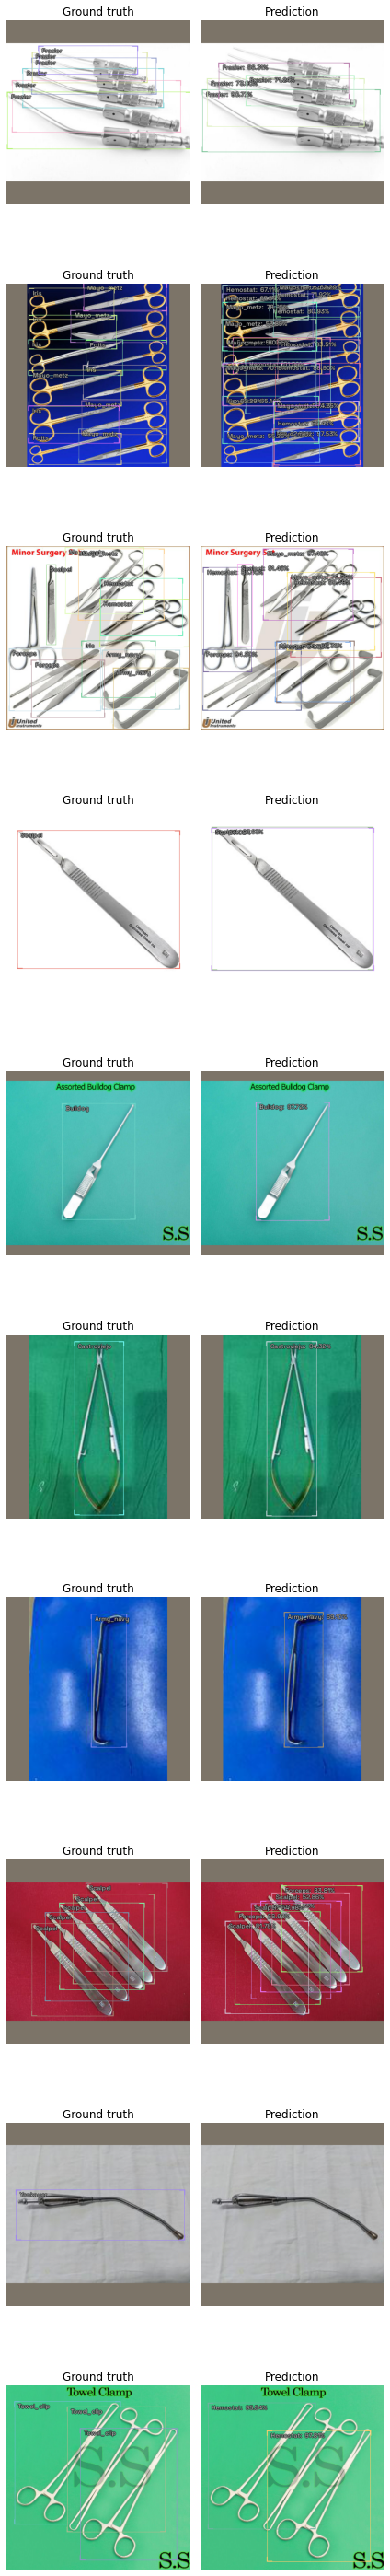

In [66]:
show_preds(preds = preds_saved[0:10])
# with detection threshold 0.5
## fair bboxes, fair classification results

In [ ]:

for pred in preds_saved:
  pred.add_component(FilepathRecordComponent())

for _ in range(len(preds_saved)): 
  preds_saved[_].set_filepath(img_files[_]) 

conv = convert_preds_to_coco_style(preds_saved) 

In [ ]:
add_info = {
    "info": {
        "year": "2021",
        "version": "1",
        "description": "Exported from roboflow.ai",
        "contributor": "",
        "url": "https://public.roboflow.ai/object-detection/undefined",
        "date_created": "2021-10-05T20:13:09+00:00"
    },
    "licenses": [
        {
            "id": 1,
            "url": "https://creativecommons.org/licenses/by/4.0/",
            "name": "CC BY 4.0"
        }
    ],
    "categories": [
        {
            "id": 0,
            "name": "instruments",
            "supercategory": "none"
        },
        {
            "id": 1,
            "name": "Army_navy",
            "supercategory": "Retractor"
        },
        {
            "id": 2,
            "name": "Bulldog",
            "supercategory": "Clamp"
        },
        {
            "id": 3,
            "name": "Castroviejo",
            "supercategory": "Needle_holder"
        },
        {
            "id": 4,
            "name": "Forceps",
            "supercategory": "Forceps"
        },
        {
            "id": 5,
            "name": "Frazier",
            "supercategory": "Suction"
        },
        {
            "id": 6,
            "name": "Hemostat",
            "supercategory": "Clamp"
        },
        {
            "id": 7,
            "name": "Iris",
            "supercategory": "Scissors"
        },
       {
            "id": 8,
            "name": "Mayo_metz",
            "supercategory": "Scissors"
        },
        {
            "id": 9,
            "name": "Needle",
            "supercategory": "Needle"
        },
        {
            "id": 10,
            "name": "Potts",
            "supercategory": "Scissors"
        },
        {
            "id": 11,
            "name": "Richardson",
            "supercategory": "Retractor"
        },
        {
            "id": 12,
            "name": "Scalpel",
            "supercategory": "Scalpel"
        },
        {
            "id": 13,
            "name": "Towel_clip",
            "supercategory": "Clamp"
        },
        {
            "id": 14,
            "name": "Weitlaner",
            "supercategory": "Retractor"
        },
        {
            "id": 15,
            "name": "Yankauer",
            "supercategory": "Suction"
        }
    ]
}

In [ ]:
pseudo = {**add_info, **conv}

f = open('pseudo.json','w') 
f.write(str(pseudo)) 
f.close()
##  edit ' to "": annot_.json

Do annotation and split in Roboflow.

Continue iterative training.